# Portfolio Diversification Benefits
This notebook demonstrates how adding more stocks to a portfolio can reduce risk through diversification.

## Setup and Imports
First, let's import our required libraries:

In [8]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns

## Data Collection
We'll use a broader set of stocks from different sectors:

In [16]:
# Define a larger set of stocks from different sectors
tickers = [
    'AAPL', 'JPM', 'JNJ', 'XOM', 'PG', 'WMT', 'MSFT', 'BAC', 'PFE', 'CVX',
    'GOOGL', 'AMZN', 'TSLA', 'NVDA', 'META', 'V', 'DIS', 'NFLX', 'KO', 'PEP',
    'CSCO', 'INTC', 'MRK', 'T', 'BA'
]







def get_stock_data(tickers, start_date='2020-01-01', end_date='2023-12-31'):
    """
    Fetches monthly returns for given stock tickers
    """
    data = pd.DataFrame()

    for ticker in tickers:
        stock = yf.download(ticker, start=start_date,
                            end=end_date, progress=False)
        monthly_returns = stock['Close'].resample('ME').last().pct_change()
        data[ticker] = monthly_returns

    return data


# Fetch our data
returns_df = get_stock_data(tickers)

## Demonstrate Diversification Effect
Let's create a function that shows how portfolio risk changes as we add more stocks:


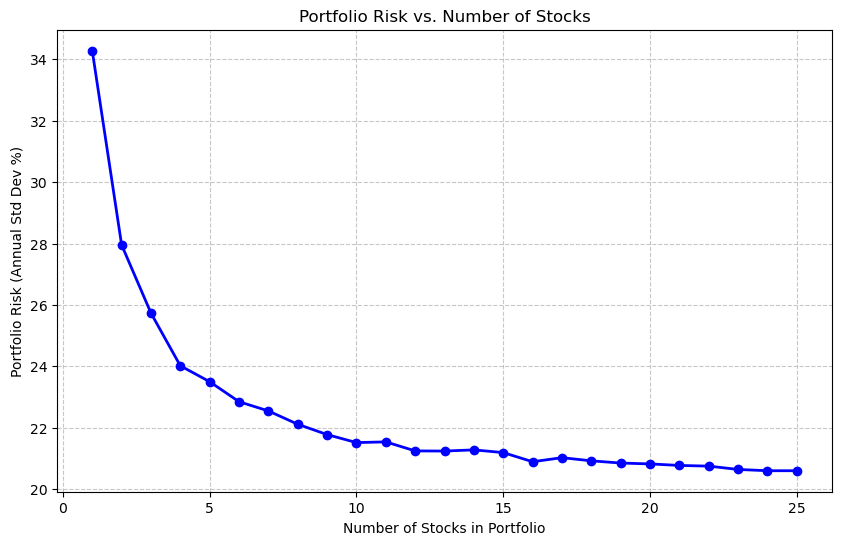

In [10]:
def calculate_portfolio_metrics(returns, num_stocks, num_simulations=500):
    """
    Calculates portfolio metrics for different sized portfolios
    """
    portfolio_risks = []

    for _ in range(num_simulations):
        # Randomly select stocks
        selected_stocks = np.random.choice(
            returns.columns, num_stocks, replace=False)
        portfolio_returns = returns[selected_stocks]

        # Equal weight portfolio
        weights = np.array([1/num_stocks] * num_stocks)

        # Calculate portfolio risk (annualized)
        portfolio_std = np.sqrt(np.dot(weights.T, np.dot(
            portfolio_returns.cov() * 12, weights))) * 100
        portfolio_risks.append(portfolio_std)

    return np.mean(portfolio_risks)


# Calculate average portfolio risk for different numbers of stocks
num_stocks_range = range(1, len(tickers) + 1)
portfolio_risks = [calculate_portfolio_metrics(
    returns_df, n) for n in num_stocks_range]

# Plot results
plt.figure(figsize=(10, 6))
plt.plot(num_stocks_range, portfolio_risks, 'b-', linewidth=2, marker='o')
plt.xlabel('Number of Stocks in Portfolio')
plt.ylabel('Portfolio Risk (Annual Std Dev %)')
plt.title('Portfolio Risk vs. Number of Stocks')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()


## Correlation Analysis
Understanding correlations is key to diversification:

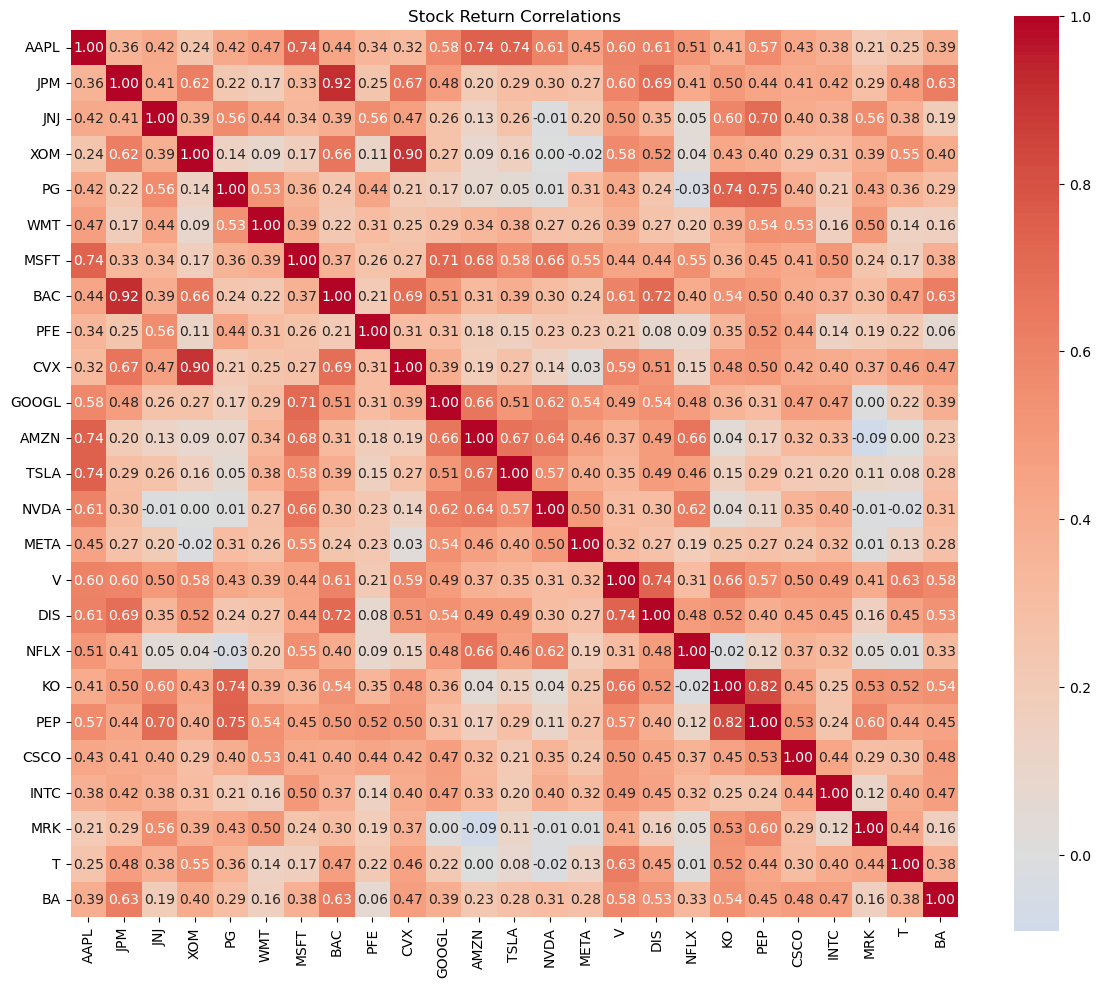

In [11]:
def plot_correlation_matrix(returns_df):
    """
    Creates and plots correlation matrix heatmap
    """
    corr_matrix = returns_df.corr()

    plt.figure(figsize=(12, 10))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0,
                fmt='.2f', square=True)
    plt.title('Stock Return Correlations')
    plt.tight_layout()
    plt.show()

    return corr_matrix


# Plot correlation matrix
corr_matrix = plot_correlation_matrix(returns_df)

## Compare Individual vs Portfolio Risk
Let's compare individual stock risks to portfolio risk:

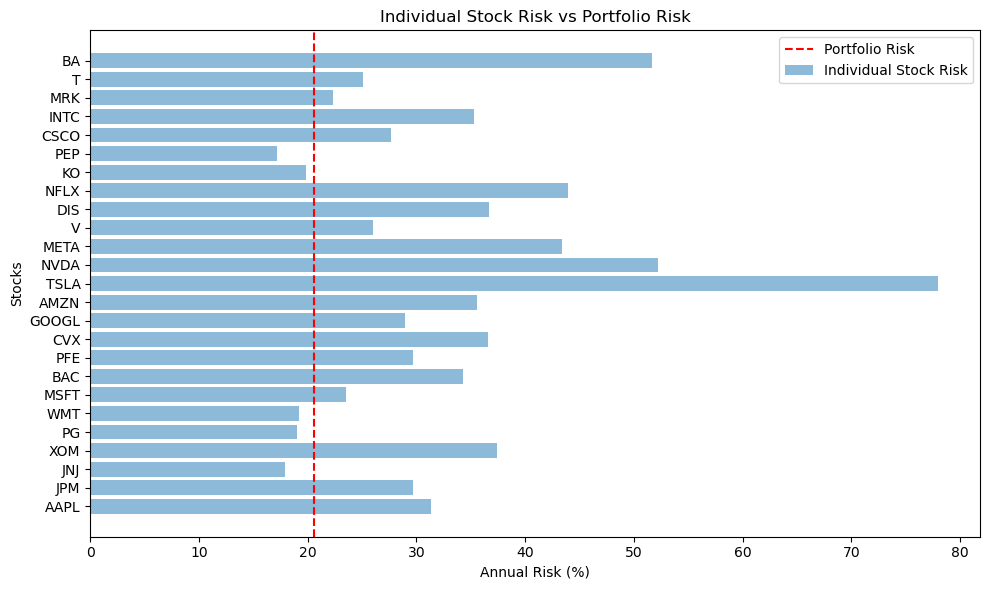


Portfolio Risk: 20.60%

Individual Stock Risks:
AAPL: 31.32%
JPM: 29.67%
JNJ: 17.93%
XOM: 37.39%
PG: 18.99%
WMT: 19.17%
MSFT: 23.55%
BAC: 34.33%
PFE: 29.67%
CVX: 36.59%
GOOGL: 28.98%
AMZN: 35.53%
TSLA: 77.95%
NVDA: 52.21%
META: 43.42%
V: 25.98%
DIS: 36.64%
NFLX: 43.93%
KO: 19.81%
PEP: 17.21%
CSCO: 27.66%
INTC: 35.34%
MRK: 22.34%
T: 25.05%
BA: 51.64%


In [14]:
def compare_individual_vs_portfolio(returns_df):
    """
    Compares individual stock risks to portfolio risk
    """
    # Calculate individual stock risks
    individual_risks = returns_df.std() * np.sqrt(12) * 100

    # Calculate equally weighted portfolio risk
    weights = np.array([1/len(returns_df.columns)] * len(returns_df.columns))
    portfolio_risk = np.sqrt(
        np.dot(weights.T, np.dot(returns_df.cov() * 12, weights))) * 100

    # Plot comparison
    plt.figure(figsize=(10, 6))
    plt.barh(range(len(individual_risks)), individual_risks,
             alpha=0.5, label='Individual Stock Risk')
    plt.axvline(x=portfolio_risk, color='r',
                linestyle='--', label='Portfolio Risk')
    plt.ylabel('Stocks')
    plt.xlabel('Annual Risk (%)')
    plt.title('Individual Stock Risk vs Portfolio Risk')
    plt.legend()
    plt.yticks(range(len(individual_risks)), returns_df.columns)
    plt.tight_layout()
    plt.show()

    return individual_risks, portfolio_risk


# Compare risks
individual_risks, portfolio_risk = compare_individual_vs_portfolio(returns_df)
print(f"\nPortfolio Risk: {portfolio_risk:.2f}%")
print("\nIndividual Stock Risks:")
for ticker, risk in zip(returns_df.columns, individual_risks):
    print(f"{ticker}: {risk:.2f}%")

## Systematic vs Unsystematic Risk
Let's decompose risk into systematic (market) and unsystematic components:

In [ ]:
def analyze_risk_components(returns_df):
    """
    Analyzes systematic and unsystematic risk components
    """
    # Get market returns (using SPY)
    spy_returns = yf.download('SPY',
                              start=returns_df.index[0],
                              end=returns_df.index[-1],
                              progress=False)['Close'].resample('ME').last().pct_change()

    # Calculate betas and R-squared for each stock
    risk_components = pd.DataFrame(index=returns_df.columns)

    for stock in returns_df.columns:
        aligned_returns = returns_df[stock].reindex(spy_returns.index).dropna()
        aligned_spy_returns = spy_returns['SPY'].loc[aligned_returns.index]

        model = np.polyfit(aligned_spy_returns, aligned_returns, 1)
        r_squared = 1 - (np.sum((aligned_returns - (model[0]*aligned_spy_returns + model[1]))**2) /
                         np.sum((aligned_returns - aligned_returns.mean())**2))

        risk_components.loc[stock, 'Systematic Risk (%)'] = r_squared * 100
        risk_components.loc[stock, 'Unsystematic Risk (%)'] = (
            1 - r_squared) * 100

    # Plot results
    risk_components.plot(kind='barh', stacked=True, figsize=(12, 6))
    plt.title('Decomposition of Risk: Systematic vs Unsystematic')
    plt.ylabel('Stocks')
    plt.xlabel('Percentage of Total Risk')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

    # Second plot: share of systematic vs. unsystematic multiplied by the total risk
    total_risk = individual_risks.loc[returns_df.columns]
    risk_components_scaled = risk_components.multiply(total_risk, axis=0)

    risk_components_scaled.plot(kind='barh', stacked=True, figsize=(12, 6))
    plt.title('Scaled Decomposition of Risk: Systematic vs Unsystematic')
    plt.ylabel('Stocks')
    plt.xlabel('Total Risk Contribution')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

    return risk_components


# Analyze risk components
risk_components = analyze_risk_components(returns_df)

TypeError: expected 1D vector for x

## Exercise for Students
1. Try different combinations of stocks and observe the diversification effect
2. Calculate the optimal number of stocks needed to achieve most diversification benefits
3. Compare diversification effects across different time periods

## Discussion Questions
1. Why does portfolio risk decrease as we add more stocks?
2. What role do correlations play in diversification?
3. Why doesn't diversification eliminate all risk?
4. How does sector diversification compare to random diversification?
